In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
# import matplotlib.patches as patches
from monai.metrics.fid import FIDMetric
from monai.metrics.mmd import MMDMetric
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/Users/rasmus/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Skole/kandidat/5.-semester/Speciale/thesis_code/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
generated_l1_vec = np.load("/users/rasmus/data/mri_vectors/generated-lambda-1.npy")
generated_l5_vec = np.load("/users/rasmus/data/mri_vectors/generated-lambda-5.npy")
generated_author_vec = np.load("/users/rasmus/data/mri_vectors/generated-from-authors.npy")
true_vec = np.load("/users/rasmus/data/mri_vectors/true-from-test-dataset.npy")
pretrain_points = np.concatenate([
    generated_l1_vec,
    generated_l5_vec,
    generated_author_vec,
    true_vec
], axis=0)
pretrain_labels = np.concatenate([
    np.zeros(generated_l1_vec.shape[0]),
    np.ones(generated_l5_vec.shape[0]),
    np.ones(generated_author_vec.shape[0])*2,
    np.ones(true_vec.shape[0])*3
], axis=0)

# ft_true_vec = np.load("/users/rasmus/data/mri_vectors/ft-true-from-test-dataset.npy")

In [18]:
true_vec.mean(), generated_l1_vec.mean(), generated_l5_vec.mean(), generated_author_vec.mean()

(0.038489077, 0.078089595, 0.11761541, 0.0692202)

In [19]:
# Fit MDS on the data
mds = MDS(n_components=2, random_state=42)
true_mds = mds.fit_transform(true_vec)
generated_l1_mds = mds.fit_transform(generated_l1_vec)
generated_l5_mds = mds.fit_transform(generated_l5_vec)
generated_author_mds = mds.fit_transform(generated_author_vec)
# ft_true_mds = mds.fit_transform(ft_true_vec)
pretrain_mds = mds.fit_transform(pretrain_points)

/Users/rasmus/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Skole/kandidat/5.-semester/Speciale/thesis_code/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:629: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/rasmus/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Skole/kandidat/5.-semester/Speciale/thesis_code/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:629: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/rasmus/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Skole/kandidat/5.-semester/Speciale/thesis_code/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:629: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix

In [20]:
true_vec[0].max(), generated_l1_vec[0].max(), generated_l5_vec[0].max(), generated_author_vec[0].max()

(0.25674748, 0.59383893, 0.7377796, 0.55784714)

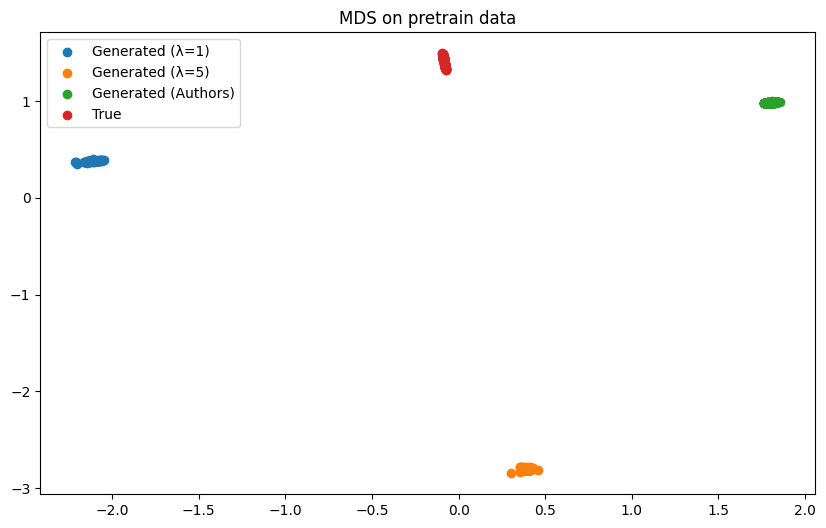

In [21]:
# Plot the pretrain mds results.
plt.figure(figsize=(10, 6))
plt.scatter(pretrain_mds[pretrain_labels == 0, 0], pretrain_mds[pretrain_labels == 0, 1], label="Generated (λ=1)")
plt.scatter(pretrain_mds[pretrain_labels == 1, 0], pretrain_mds[pretrain_labels == 1, 1], label="Generated (λ=5)")
plt.scatter(pretrain_mds[pretrain_labels == 2, 0], pretrain_mds[pretrain_labels == 2, 1], label="Generated (Authors)")
plt.scatter(pretrain_mds[pretrain_labels == 3, 0], pretrain_mds[pretrain_labels == 3, 1], label="True")
plt.legend()
plt.title("MDS on pretrain data")
plt.show()

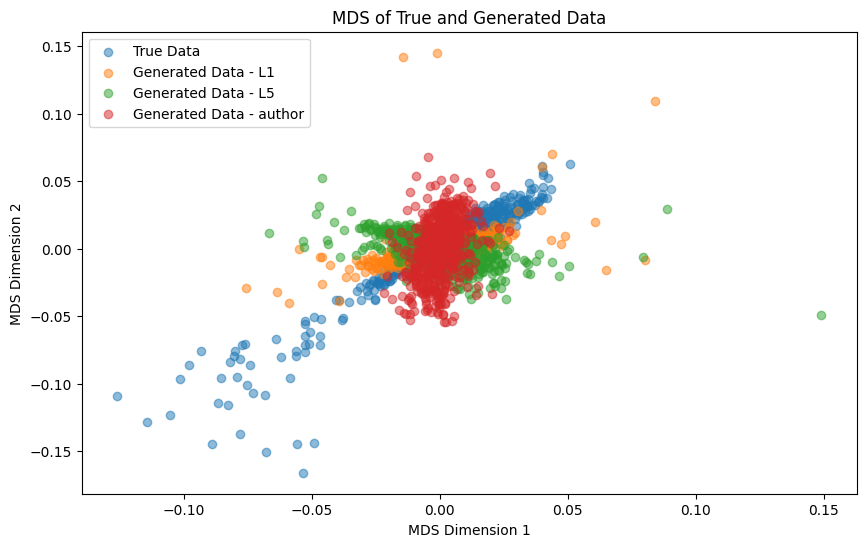

In [22]:
from matplotlib.patches import Ellipse

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(true_mds[:, 0], true_mds[:, 1], label='True Data', alpha=0.5)
plt.scatter(generated_l1_mds[:, 0], generated_l1_mds[:, 1], label='Generated Data - L1', alpha=0.5)
plt.scatter(generated_l5_mds[:, 0], generated_l5_mds[:, 1], label='Generated Data - L5', alpha=0.5)
plt.scatter(generated_author_mds[:, 0], generated_author_mds[:, 1], label='Generated Data - author', alpha=0.5)
# plt.scatter(ft_true_mds[:, 0], ft_true_mds[:, 1], label='True Fine-tune Data', alpha=0.5)
plt.legend()
plt.title('MDS of True and Generated Data')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

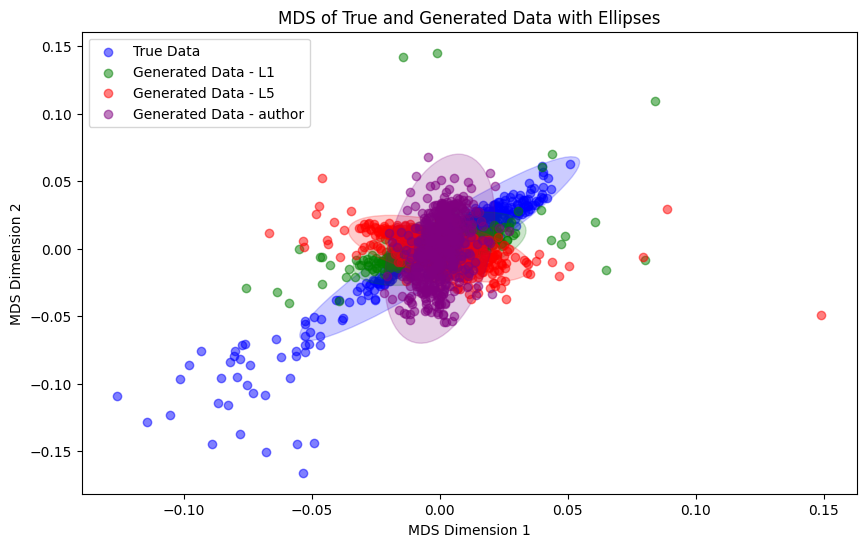

In [24]:
def plot_ellipse(ax, data, label, color, factor=1.0):
    cov = np.cov(data, rowvar=False)
    mean = np.mean(data, axis=0)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * factor * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.2)
    ax.add_patch(ellipse)
    ax.scatter(data[:, 0], data[:, 1], label=label, alpha=0.5, color=color)

fig, ax = plt.subplots(figsize=(10, 6))
plot_ellipse(ax, true_mds, 'True Data', 'blue', factor=2.0)
plot_ellipse(ax, generated_l1_mds, 'Generated Data - L1', 'green', factor=2.0)
plot_ellipse(ax, generated_l5_mds, 'Generated Data - L5', 'red', factor=2.0)
plot_ellipse(ax, generated_author_mds, 'Generated Data - author', 'purple', factor=3.0)
# plot_ellipse(ax, ft_true_mds, 'True Fine-tune Data', 'orange', factor=2.0)
ax.legend()
ax.set_title('MDS of True and Generated Data with Ellipses')
ax.set_xlabel('MDS Dimension 1')
ax.set_ylabel('MDS Dimension 2')
plt.show()

In [28]:
true_torch_vec = torch.from_numpy(true_vec)
generated_l1_torch_vec = torch.from_numpy(generated_l1_vec)
generated_l5_torch_vec = torch.from_numpy(generated_l5_vec)
generated_author_torch_vec = torch.from_numpy(generated_author_vec)

In [29]:
fid = FIDMetric()
fid_score_author = fid(true_torch_vec, generated_author_torch_vec)
fid_score_l1 = fid(true_torch_vec, generated_l1_torch_vec)
fid_score_l5 = fid(true_torch_vec, generated_l5_torch_vec)
fid_score_l15 = fid(generated_l1_torch_vec, generated_l5_torch_vec)
fid_score_l1, fid_score_l5, fid_score_l15, fid_score_author

(tensor(7.9515, dtype=torch.float64),
 tensor(15.2080, dtype=torch.float64),
 tensor(18.0880, dtype=torch.float64),
 tensor(6.1348, dtype=torch.float64))